Purpose: Do analyses related to the new coexpression network generated Apr. 2, 2024.<br>
Author: Anna Pardo<br>
Date initiated: Apr. 3, 2024

In [1]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statistics
import scipy.stats as stats
import numpy as np
from statsmodels.stats.multitest import fdrcorrection
from venn import venn
from matplotlib.patches import Patch
import json

In [2]:
# load coexpression module data
directory = "../../data/WGCNA_Apr2024/modules/"
modgenes = {}
for filename in os.listdir(directory):
    if filename.endswith("_genes.csv"):
        modname = filename.split("_")[0]
        df = pd.read_csv(directory+filename,sep="\t",header="infer")
        #print(df.head())
        genelist = list(df["x"])
        modgenes[modname] = genelist

In [3]:
len(modgenes.keys())

23

In [4]:
# save modgenes
with open("../../data/WGCNA_Apr2024/genes_in_modules.json","w+") as outfile:
    json.dump(modgenes,outfile,indent=4)

In [5]:
# start with basic exploration of the modules
dfdict = {"Module":[],"Number of genes":[]}
for k,v in modgenes.items():
    dfdict["Module"].append(k)
    dfdict["Number of genes"].append(len(v))
modinfo = pd.DataFrame(dfdict)

In [6]:
modinfo.sort_values(by="Number of genes",axis=0)

,Module,Number of genes
15,white,103
16,darkorange,106
6,orange,155
1,darkgrey,159
13,darkturquoise,174
4,darkgreen,185
10,darkred,260
8,royalblue,261
12,lightyellow,322
19,lightgreen,443


In [7]:
modinfo.mean()

/tmp/ipykernel_159/1814007687.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  modinfo.mean()


Number of genes    1618.086957
dtype: float64

In [8]:
# load transcription factor & core gene dataframes
tf = pd.read_csv("../../data/data.csv",sep=",",header="infer")
pctf = pd.read_csv("../../data/psyn_core_genes_TFs.tsv",sep="\t",header="infer")
actf = pd.read_csv("../../data/allsamp_core_genes_TFs.tsv",sep="\t",header="infer")
psyn_cg_info = pd.read_csv("../../data/core_genes_psyn_info_30-Mar-2024.tsv",sep="\t",header="infer")
all_cg_info = pd.read_csv("../../data/core_genes_all_info_30-Mar-2024.tsv",sep="\t",header="infer")

Next operation: Find whether modules containing the core gene TFs (of each family) are enriched in non-TF core genes.

In [9]:
# load tpm
tpm = pd.read_csv("../../data/rawtpm_bptreat_noPEG.tsv",sep="\t",header="infer")

In [10]:
# wrangle tpm data
ttpm = tpm.set_index("Sample").drop(["BioProject","Treatment"],axis=1).transpose().reset_index().rename(columns={"index":"GeneID"})


In [11]:
# Fisher table will be set up as isCore, inModule
def mod_data_setup(coregeneset,modulegenes):
    coreornot = []
    modornot = []
    for g in list(ttpm["GeneID"].unique()):
        if g in modulegenes:
            modornot.append("Yes")
        else:
            modornot.append("No")
        if g in coregeneset:
            coreornot.append("Yes")
        else:
            coreornot.append("No")
    df = pd.DataFrame(list(zip(list(ttpm["GeneID"].unique()),coreornot,modornot)),columns=["GeneID","isCore","inModule"])
    return df

In [12]:
def mod_fisher(coregeneset,module):
    # get list of genes in module
    mg = modgenes[module]
    df = mod_data_setup(coregeneset,mg)
    data = pd.crosstab(index=df["inModule"],columns=df["isCore"])
    odds_ratio, p_value = stats.fisher_exact(data)
    return (odds_ratio,p_value)

In [13]:
# define a function to do this
def test_module_enrichment(cgtf,cgdf):
    # subset to genes that are not in the set of TFs of interest
    nontf = cgdf[~cgdf["GeneID"].isin(list(cgtf["gene ID"]))]
    pvals = [mod_fisher(list(nontf["GeneID"].unique()),i)[1] for i in modgenes.keys()]
    odds = [mod_fisher(list(nontf["GeneID"].unique()),i)[0] for i in modgenes.keys()]
    ids = [i for i in modgenes.keys()]
    modres = pd.DataFrame(list(zip(ids,pvals,odds)),columns=["Module","P-value","Odds Ratio"])
    modres["P-adj"] = fdrcorrection(modres["P-value"])[1]
    return modres

In [14]:
# for each gene in pctf and actf, find what module(s) it is in and append as a column
mods = []
for g in list(pctf["gene ID"]):
    for m in modgenes.keys():
        l = modgenes[m]
        if g in l:
            mods.append(m)
pctf["Module"] = mods

In [15]:
mods = []
for g in list(actf["gene ID"]):
    for m in modgenes.keys():
        l = modgenes[m]
        if g in l:
            mods.append(m)
actf["Module"] = mods

In [16]:
all_mod_enrich = test_module_enrichment(actf,all_cg_info)

In [17]:
psyn_mod_enrich = test_module_enrichment(pctf,psyn_cg_info)

In [18]:
all_mod_enrich[all_mod_enrich["P-adj"]<0.05]

,Module,P-value,Odds Ratio,P-adj
0,blue,3.244347e-04,0.712875,8.291108e-04
2,green,3.323927e-22,3.639786,7.645032e-21
3,turquoise,8.155556e-07,0.606258,3.126297e-06
7,yellow,7.718629e-11,0.253247,4.438211e-10
8,royalblue,1.365008e-11,6.267795,1.046506e-10
14,lightcyan,1.594176e-04,2.658065,4.598601e-04
17,salmon,5.371105e-03,0.195977,1.235354e-02
18,pink,1.073429e-07,2.707303,4.937774e-07
19,lightgreen,1.599513e-04,2.737748,4.598601e-04
21,cyan,9.580048e-03,1.705065,2.003101e-02


In [19]:
psyn_mod_enrich[psyn_mod_enrich["P-adj"]<0.05]

,Module,P-value,Odds Ratio,P-adj
0,blue,1.589811e-04,0.645874,4.570705e-04
2,green,1.098635e-15,3.577990,2.526860e-14
3,turquoise,6.114974e-08,0.505560,3.516110e-07
7,yellow,5.713235e-07,0.293769,2.628088e-06
8,royalblue,5.281697e-05,4.263892,1.735415e-04
9,purple,2.067855e-02,0.232009,3.963389e-02
12,lightyellow,3.713141e-04,3.419414,9.489137e-04
14,lightcyan,4.545469e-13,5.890393,5.227290e-12
18,pink,9.702426e-04,2.183577,2.231558e-03
19,lightgreen,1.932314e-03,2.668373,4.040293e-03


In [20]:
# subset to the modules containing the genes of interest
all_intmods = list(actf["Module"].unique())
all_intmodenrich = all_mod_enrich[all_mod_enrich["Module"].isin(all_intmods)]

In [21]:
psyn_intmods = list(pctf["Module"].unique())
psyn_intmodenrich = psyn_mod_enrich[psyn_mod_enrich["Module"].isin(psyn_intmods)]

In [22]:
psyn_intmodenrich

,Module,P-value,Odds Ratio,P-adj
0,blue,1.589811e-04,0.645874,4.570705e-04
2,green,1.098635e-15,3.577990,2.526860e-14
3,turquoise,6.114974e-08,0.505560,3.516110e-07
5,greenyellow,6.789127e-01,1.081061,7.479031e-01
6,orange,4.287278e-01,0.000000,5.800435e-01
11,magenta,4.952389e-01,1.227605,6.328052e-01
12,lightyellow,3.713141e-04,3.419414,9.489137e-04
18,pink,9.702426e-04,2.183577,2.231558e-03
19,lightgreen,1.932314e-03,2.668373,4.040293e-03
20,black,6.828681e-01,0.843909,7.479031e-01


In [23]:
all_intmodenrich[all_intmodenrich["P-adj"]<0.05]

,Module,P-value,Odds Ratio,P-adj
0,blue,3.244347e-04,0.712875,8.291108e-04
2,green,3.323927e-22,3.639786,7.645032e-21
3,turquoise,8.155556e-07,0.606258,3.126297e-06
8,royalblue,1.365008e-11,6.267795,1.046506e-10
18,pink,1.073429e-07,2.707303,4.937774e-07
19,lightgreen,1.599513e-04,2.737748,4.598601e-04
21,cyan,9.580048e-03,1.705065,2.003101e-02
22,grey60,8.636594e-14,3.448175,9.932083e-13


In [24]:
psyn_intmodenrich[psyn_intmodenrich["P-adj"]<0.05]

,Module,P-value,Odds Ratio,P-adj
0,blue,1.589811e-04,0.645874,4.570705e-04
2,green,1.098635e-15,3.577990,2.526860e-14
3,turquoise,6.114974e-08,0.505560,3.516110e-07
12,lightyellow,3.713141e-04,3.419414,9.489137e-04
18,pink,9.702426e-04,2.183577,2.231558e-03
19,lightgreen,1.932314e-03,2.668373,4.040293e-03
21,cyan,1.105087e-05,2.613065,4.236168e-05
22,grey60,4.887443e-10,3.414788,3.747040e-09


In [25]:
len(all_intmods)

13

In [26]:
len(psyn_intmods)

12

In [27]:
# create a dictionary for the Venn diagram
venndict = {"All tissues":set(all_intmods),"Photosynthetic tissues":set(psyn_intmods)}

<AxesSubplot: >

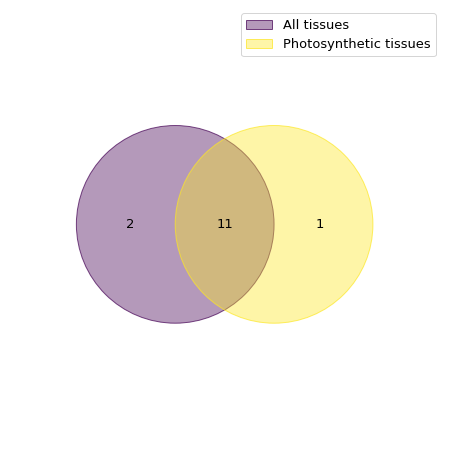

In [28]:
venn(venndict)

In [29]:
all_intmods

['blue',
 'greenyellow',
 'green',
 'pink',
 'turquoise',
 'lightgreen',
 'orange',
 'grey60',
 'cyan',
 'magenta',
 'royalblue',
 'lightyellow',
 'darkgreen']

In [30]:
psyn_intmods

['grey60',
 'turquoise',
 'pink',
 'black',
 'blue',
 'green',
 'orange',
 'lightgreen',
 'magenta',
 'cyan',
 'lightyellow',
 'greenyellow']

In [31]:
psyn_cg_info.head()

,GeneID,Name,Upregulated,Downregulated,From_RF,From_Set_Ops
0,Zm00001eb395600,galactinol synthase3,Y,Y,Y,N
1,Zm00001eb372220,NaN,Y,N,N,Y
2,Zm00001eb127760,NaN,Y,N,N,Y
3,Zm00001eb018750,NaN,N,Y,Y,N
4,Zm00001eb042520,NaN,N,Y,N,Y


In [32]:
# plot the percentage of each module that is core genes (from each core gene set)
## relevant df: modinfo
# step 1: keep only the modules that actually contain core genes
# add a Module column to psyn_cg_info and all_cg_info

mods = []
for g in list(psyn_cg_info["GeneID"]):
    for m in modgenes.keys():
        l = modgenes[m]
        if g in l:
            mods.append(m)
psyn_cg_info["Module"] = mods
psyn_cg_info.head()

,GeneID,Name,Upregulated,Downregulated,From_RF,From_Set_Ops,Module
0,Zm00001eb395600,galactinol synthase3,Y,Y,Y,N,lightcyan
1,Zm00001eb372220,NaN,Y,N,N,Y,turquoise
2,Zm00001eb127760,NaN,Y,N,N,Y,green
3,Zm00001eb018750,NaN,N,Y,Y,N,grey60
4,Zm00001eb042520,NaN,N,Y,N,Y,lightcyan


In [33]:
mods = []
for g in list(all_cg_info["GeneID"]):
    for m in modgenes.keys():
        l = modgenes[m]
        if g in l:
            mods.append(m)
all_cg_info["Module"] = mods
all_cg_info.head()

,GeneID,Name,Upregulated,Downregulated,From_RF,From_Set_Ops,Module
0,Zm00001eb239670,pyrabactin resistance-like protein3,Y,Y,Y,N,greenyellow
1,Zm00001eb042520,NaN,N,Y,N,Y,lightcyan
2,Zm00001eb310220,NaN,Y,Y,Y,N,green
3,Zm00001eb156030,NaN,N,N,N,N,turquoise
4,Zm00001eb107400,MAP kinase kinase kinase27,Y,N,Y,N,blue


In [34]:
# define a function to find how many core genes are in a given module
def find_ncore_module(module,cgdf):
    subdf = cgdf[cgdf["Module"]==module]
    return len(list(subdf["GeneID"].unique()))

In [35]:
ncore_all = []
ncore_psyn = []
for i in range(len(modinfo.index)):
    ncore_all.append(find_ncore_module(modinfo.iloc[i,0],all_cg_info))
    ncore_psyn.append(find_ncore_module(modinfo.iloc[i,0],psyn_cg_info))
modinfo["N_AllCore"] = ncore_all
modinfo["N_PsynCore"] = ncore_psyn

In [36]:
# calculate percentages
pct_all = []
pct_psyn = []
for i in range(len(modinfo.index)):
    pct_all.append((modinfo.iloc[i,2]/modinfo.iloc[i,1])*100)
    pct_psyn.append((modinfo.iloc[i,3]/modinfo.iloc[i,1])*100)
modinfo["Percent_AllCore"] = pct_all
modinfo["Percent_PsynCore"] = pct_psyn

In [37]:
modinfo.head()

,Module,Number of genes,N_AllCore,N_PsynCore,Percent_AllCore,Percent_PsynCore
0,blue,10959,158,105,1.441737,0.958117
1,darkgrey,159,2,0,1.257862,0.000000
2,green,1762,111,81,6.299659,4.597049
3,turquoise,9813,130,74,1.324773,0.754102
4,darkgreen,185,5,1,2.702703,0.540541


In [38]:
# re-wrangle the data for plotting
# columns should include: Module, Percent Core Genes, Tissue Set (all or photosynthetic)

plotdict = {"Module":[],"Percent Core Genes":[],"Tissue Set":[]}
for i in range(len(modinfo.index)):
    plotdict["Module"].append(modinfo.iloc[i,0])
    plotdict["Module"].append(modinfo.iloc[i,0])
    plotdict["Percent Core Genes"].append(modinfo.iloc[i,4])
    plotdict["Percent Core Genes"].append(modinfo.iloc[i,5])
    plotdict["Tissue Set"].append("All")
    plotdict["Tissue Set"].append("Photosynthetic")

In [39]:
plotdf = pd.DataFrame(plotdict)
plotdf = plotdf.sort_values(by=["Percent Core Genes"],axis=0,ascending=False)

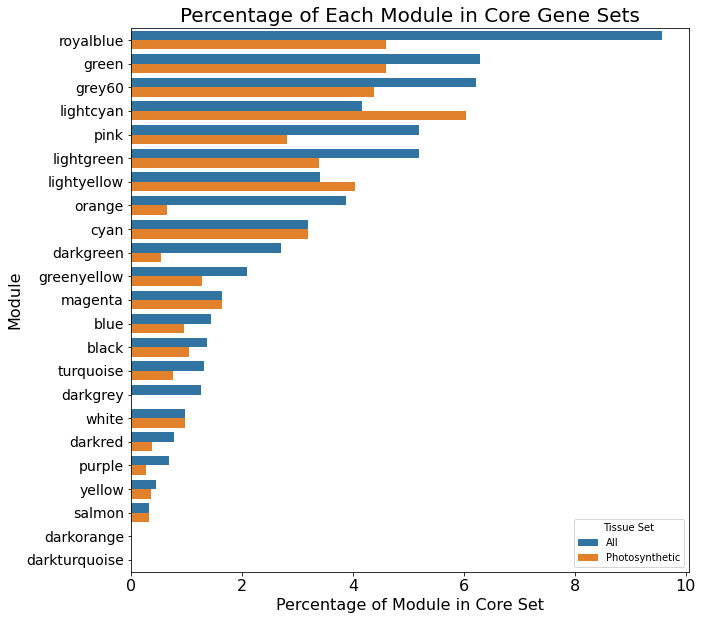

In [40]:
ax = plt.subplots(figsize=(10,10))
ax = sns.barplot(y=plotdf["Module"],x=plotdf["Percent Core Genes"],hue=plotdf["Tissue Set"])
plt.title("Percentage of Each Module in Core Gene Sets",fontsize=20)
plt.ylabel("Module",fontsize=16)
plt.xlabel("Percentage of Module in Core Set",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.savefig("../../figures/modules_percent_core.svg",bbox_inches="tight")